In [1]:
import pandas as pd 
import numpy as np
import itertools

from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file
from ydata_profiling.visualisation.plot import timeseries_heatmap
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tools.eval_measures import rmse
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import pmdarima

from scipy.stats.distributions import chi2
import scipy.stats

from math import sqrt
import pylab

# sns.set()

C:\Users\johnh\anaconda3\envs\tsa365ds2\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\johnh\anaconda3\envs\tsa365ds2\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


#### Helper Functions

In [2]:
def boxplot_graph(df, column = 'ASSET', melt_ = True):
    
    if melt_:
        fig, ax = plt.subplots(figsize = (14,8))
        ax = sns.boxplot(data = df, x = 'YEAR', y = column)
        ax.tick_params(axis='x', rotation=45)
        plt.show()
        
    else:
        df_box = pd.melt(df)
        df_box = df_box.loc[df_box['variable'].isin(['ASSET', 'DEPDOM'])]
        df_box['value'] = df_box['value'].astype(float)
        df_box
        
        fig, ax = plt.subplots(figsize = (14,8))
        ax = sns.boxplot(x="variable", y="value", data=df_box)

        plt.show()

        
def get_fdic_distribution_analysis(fdic_desc):
    
    fdic_desc = fdic_desc.iloc[4:-1].reset_index()
    fdic_desc['ASSET'] = fdic_desc['ASSET'] * 1e-6
    fdic_desc['DEPDOM'] = fdic_desc['DEPDOM'] * 1e-6
    
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize = (14,8))

    fig.suptitle('Assets and Deposits by Percentiles')
    for i, col in enumerate(fdic_desc.columns[1:]):
        #ax[i].set_title('{} Analysis by Selected Percentiles'.format(col))
        sns.barplot(data = fdic_desc, y = col, x = 'index', ax = ax[i])

    plt.show()
    

def get_rates_distribution_analysis(rates):
    
    rates = rates.iloc[4:-1,:-1].reset_index()
    
    fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize = (14,8))

    fig.suptitle('Rates by Percentiles')
    for i, col in enumerate(rates.columns[1:]):
        ax[i].set_title('{} Analysis by Selected Percentiles'.format(col))
        sns.barplot(data = rates, y = col, x = 'index', ax = ax[i])

    plt.show()


def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p
    
    
def augmented_df_with_data(variable):
    """
    Display the adfuller info in a friendlier fashion
    """
    print('Augmented Dickey-Fuller Test')

    df_test = sts.adfuller(variable)

    dfout = pd.Series(df_test[0:4], index = ['ADF test statistic:','p-value:','# lags used:','# observations:'])

    for key, val in df_test[4].items():

        dfout[f'critical value at ({key}):'] = val

    dfout['Best AIC:'] = df_test[5]
    print(dfout)
    
def seasonal_decompose_groomed(data_series, model, title, figsize = (20,8)):
    """
    This function does a little grooming on the seasonal_decompose().plot()
    
    """

    df = seasonal_decompose(data_series, model = model)

    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize= figsize)

    fig.suptitle(title)

    df.observed.plot(ax=ax1)
    df.trend.plot(ax=ax2)
    df.seasonal.plot(ax=ax3)
    df.resid.plot(ax=ax4)

    labels_list = ['Observed', 'Trend', 'Seasonal', 'Residual']

    for num, i in enumerate((ax1,ax2,ax3, ax4)):
        i.set_ylabel(labels_list[num])

        
def get_banks_portfolio_dataframe(df, name_list):

    pivoted = df.loc[df['NAME'].isin(name_list), :]
    tsa_df = pd.pivot_table(data = pivoted, index = ['REPDTE'], columns = ['NAME'], values = ['ASSET'], aggfunc = np.sum)
    tsa_df = tsa_df.iloc[83:].fillna(method = 'ffill')
    tsa_df.columns = [' '.join(col).strip() for col in tsa_df.columns.values]
    tsa_df.columns = tsa_df.columns.str.replace('ASSET ', '', regex = True)
    tsa_df.index = pd.DatetimeIndex(tsa_df.index.values,
                                   freq="Q-DEC")
    tsa_df['GROUPTOT'] = tsa_df.sum(axis = 1)

    return tsa_df


def add_noise_to_feature(df, date_field, field_name):

    df_grouped = df.groupby(date_field)[[field_name]].sum()
    df_grouped.index = pd.DatetimeIndex(df_grouped.index.values, freq="Q-DEC")
    df_grouped[ field_name + 'PCTCHG'] = df_grouped[field_name].pct_change(1)*100
    df_grouped[field_name + 'WN'] = np.random.normal(loc = df_grouped[field_name].mean(), scale = df_grouped[field_name].std(), size = len(df_grouped))

    return df_grouped


def validation_estimation(df, df_validation, model_list, model_results, field = 'ASSET', thresh = -10):
    
    if len(model_list) == len(model_results):
        
        thresh = df.index[thresh]
        test = df[thresh:]
                
        for num, mod in enumerate(model_list):
            mae = mean_squared_error(test[field], test[model_results[num]])
            rmse = np.sqrt(mae).round(2)
            mape = np.round(np.mean(np.abs(test[field] - test[model_results[num]]) / test[field])*100,2)
            
            temp_df = pd.DataFrame({'Approach': [mod], 'MAE': [mae], 'RMSE': [rmse], 'MAPE': [mape]})
            
            df_validation = pd.concat([df_validation, temp_df])
             
    else:
        print('Review the lenght of your lists')
        
    return df_validation.reset_index(drop = True)

### Data: Initial review

On this project, we will use three datasets to run our time series analysis.  These are the datesets in question.

1. **FDIC Dataset**  Frequency of the data is quarterly
1. **FRED Rates** Frequency of the data is business day
1. **Stock data** Frequency of the data is business day


#### FDIC Dataset

Each or row represents a bank in a given reporting date (_REPDTE_)

In [3]:
# df = pd.read_csv('/kaggle/input/fdic-banks-assets-and-deposits-for-time-series/fdic_tsa_df.csv')
df = pd.read_csv('fdic_tsa_df.csv')
df = df.iloc[:,1:]
df['REPDTE'] = pd.to_datetime(df['REPDTE'])
df.head()

REPDTE  RSSDID                          NAME    ASSET     DEPDOM
0 2023-03-31  599643                     Ergo Bank   218750   181522.0
1 2023-03-31   93244           Woodford State Bank   401607   319980.0
2 2023-03-31   12647           Portage County Bank   201164   173112.0
3 2023-03-31   20053                 Security Bank   166601   143959.0
4 2023-03-31  722544  National Exchange Bank&Trust  2689368  2165891.0

There is only one quarter with null data for domestic deposits (_DEPDOM_), corresponding to **"Continental Savings Bank** during the 4th quarter of 1996.  I will fill this null by forward filling this data point.

In [4]:
df.isnull().sum()

REPDTE    0
RSSDID    0
NAME      0
ASSET     0
DEPDOM    1
dtype: int64

In [5]:
df.loc[df['DEPDOM'].isnull()]

REPDTE  RSSDID                      NAME   ASSET  DEPDOM
830263 1996-12-31  258771  Continental Savings Bank  724833     NaN

These are the definitions of each feature:

|**Feature Name**|**Definition**|
|:--|:--|
|**REPDTE**|Report Date. Dates correspond to the quarterly closing dates of each financial institution.|
|**RSSDID**|An unique identifier assigned to financial institutions by the Federal Reserve.|
|**NAME**|Refers to the name of the financial institution.|
|**ASSET**|Asset size reported by the financial institution at the report date.|
|**DEPDOM**|Deposits held in domestic offices.|

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623861 entries, 0 to 1623860
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   REPDTE  1623861 non-null  datetime64[ns]
 1   RSSDID  1623861 non-null  int64         
 2   NAME    1623861 non-null  object        
 3   ASSET   1623861 non-null  int64         
 4   DEPDOM  1623860 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 61.9+ MB


In [7]:
df['YEAR'] = df.REPDTE.dt.year

This description leads to conclude that the data is not normally distributed and long right tail is expected.

In [8]:
df.describe().style.format("{:,.2f}")

This assumption holds up across, when broken down by year

_Note:_ The analysis is taking RSSDID face value.  Umbrella entities are not considered for this analysis.

In [9]:
df.groupby('YEAR')['ASSET'].agg(['mean', 'std', 'min', 'max'])[:5].style.format("{:,.2f}")

This trend is more noticeable when analyzing more recent data.  

In [10]:
df.groupby('YEAR')['ASSET'].agg(['mean', 'std', 'min', 'max'])[-5:].style.format("{:,.2f}")

#### Rates dataset

A group of rates from FRED were selected as exogenous variables.

In [11]:
rates = pd.read_csv('df_consol_rates.csv')
rates = rates.iloc[:,1:].copy()
rates['date'] = pd.to_datetime(rates['date'])
rates['dayofweek'] =  rates['date'].dt.weekday.map({
                                                    0: 'Monday',
                                                    1: 'Tuesday',
                                                    2: 'Wednesday',
                                                    3: 'Thursday',
                                                    4: 'Friday',
                                                    5: 'Saturday',
                                                    6: 'Sunday'
                                                    })

In [12]:
rates.head()

date quarter   DGS1  DGS10  DGS1MO   DGS2  DGS20   DGS3  DGS30  \
0 1980-01-01  1980Q1    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
1 1980-01-02  1980Q1  11.89  10.50     NaN  11.39  10.23  10.77  10.23   
2 1980-01-03  1980Q1  12.25  10.60     NaN  11.45  10.37  10.79  10.31   
3 1980-01-04  1980Q1  12.25  10.66     NaN  11.47  10.42  10.81  10.34   
4 1980-01-05  1980Q1    NaN    NaN     NaN    NaN    NaN    NaN    NaN   

   DGS3MO   DGS5  DGS6MO   DGS7  dayofweek  
0     NaN    NaN     NaN    NaN    Tuesday  
1     NaN  10.52     NaN  10.51  Wednesday  
2     NaN  10.54     NaN  10.59   Thursday  
3     NaN  10.62     NaN  10.63     Friday  
4     NaN    NaN     NaN    NaN   Saturday

As opposed to the FDIC, this data has plenty more null values.

In [13]:
rates.isnull().sum()

date             0
quarter          0
DGS1          5034
DGS10         5034
DGS1MO       10428
DGS2          5034
DGS20         6723
DGS3          5034
DGS30         5034
DGS3MO        5452
DGS5          5034
DGS6MO        5452
DGS7          5034
dayofweek        0
dtype: int64

Most of the features here reflect all days, including Saturday and Sunday.  **DGS1MO** has many more nulls as the series starts later.

_Note:_ DGS1MO represents Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis 

In [14]:
rates.loc[rates.DGS1MO.isnull()][-15:-10]

date quarter  DGS1  DGS10  DGS1MO  DGS2  DGS20  DGS3  DGS30  \
15909 2023-07-23  2023Q3   NaN    NaN     NaN   NaN    NaN   NaN    NaN   
15915 2023-07-29  2023Q3   NaN    NaN     NaN   NaN    NaN   NaN    NaN   
15916 2023-07-30  2023Q3   NaN    NaN     NaN   NaN    NaN   NaN    NaN   
15922 2023-08-05  2023Q3   NaN    NaN     NaN   NaN    NaN   NaN    NaN   
15923 2023-08-06  2023Q3   NaN    NaN     NaN   NaN    NaN   NaN    NaN   

       DGS3MO  DGS5  DGS6MO  DGS7 dayofweek  
15909     NaN   NaN     NaN   NaN    Sunday  
15915     NaN   NaN     NaN   NaN  Saturday  
15916     NaN   NaN     NaN   NaN    Sunday  
15922     NaN   NaN     NaN   NaN  Saturday  
15923     NaN   NaN     NaN   NaN    Sunday

These are the definitions of each feature:

|**Feature Name**|**Definition**|
|:--|:--|
|DGS1|Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis|
|DGS10|Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis|
|DGS1MO|Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis|
|DGS2|Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis|
|DGS20|Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis|
|DGS3|Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis|
|DGS30|Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis|
|DGS3MO|Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis|
|DGS5|Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis|
|DGS6MO|Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis|
|DGS7|Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis|


In [15]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15953 entries, 0 to 15952
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15953 non-null  datetime64[ns]
 1   quarter    15953 non-null  object        
 2   DGS1       10919 non-null  float64       
 3   DGS10      10919 non-null  float64       
 4   DGS1MO     5525 non-null   float64       
 5   DGS2       10919 non-null  float64       
 6   DGS20      9230 non-null   float64       
 7   DGS3       10919 non-null  float64       
 8   DGS30      10919 non-null  float64       
 9   DGS3MO     10501 non-null  float64       
 10  DGS5       10919 non-null  float64       
 11  DGS6MO     10501 non-null  float64       
 12  DGS7       10919 non-null  float64       
 13  dayofweek  15953 non-null  object        
dtypes: datetime64[ns](1), float64(11), object(2)
memory usage: 1.7+ MB


Rates have max levels that are way higher than the numbers reported at 75 percentile.  A graph is created to see the origin of this.  As data started in the 1980s, my intuition is that those numbers happened in the oil crisis from the 1970s and 1980s.

In [16]:
rates.describe().style.format("{:,.2f}")

In [17]:
rates['YEAR'] = rates.date.dt.year

Max rates are extremely high.  Therefore, a historical chart would help us see where those super high rates are located.

In [18]:
px.line(data_frame = rates, y = 'DGS10', x  = 'date')

This project is not focused on analyzing rates, but using them as exogenous factors when implementing more complex models.  Therefore, we will just taking a sample rate to analyze dispersion.

As expected, dispersion is explained by historical reasons.  Min and Max values in a year are NOT as dispersed as the volumes we see on the FDIC side.

In [19]:
rates.groupby('YEAR')['DGS10'].agg(['mean', 'std', 'min', 'max'])[:5].style.format("{:,.2f}")

In [20]:
rates.groupby('YEAR')['DGS10'].agg(['mean', 'std', 'min', 'max'])[-5:].style.format("{:,.2f}")

#### Stocks dataset

I have found a list of 49 financial institutions that are in the stock market.  However, I just selected a small group of banks in case we use them as either exogenous variables, or features in more complex models.

In [21]:
stocks = pd.read_csv('df_simplified_port.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'] )
stocks.rename(columns = {'Date': 'date'}, inplace = True)

In [22]:
stocks.head()

date       SP500       JPM  JPM_Vol       BAC  BAC_Vol       WFC  \
0 1984-01-03  164.039993  2.132280   385650  1.163508   194400  0.391078   
1 1984-01-04  166.779999  2.223144   292500  1.174282   139200  0.391078   
2 1984-01-05  168.809998  2.295835   344250  1.179668   687200  0.397026   
3 1984-01-06  169.279999  2.271604   194400  1.195829  1779200  0.394052   
4 1984-01-09  168.899994  2.277662   216450  1.206602  1110400  0.391078   

   WFC_Vol         C    C_Vol        BK  BK_Vol  
0   494400  8.559437    92048  1.025569   35094  
1   614400  8.790149   296145  1.037492  266039  
2  1627200  8.951653   724337  1.053393  344152  
3   885600  9.159286   347470  1.065318  243397  
4  1219200  9.090076  1576867  1.069293   54340

This dataset only reports business days.  Therefore, there is no null data in it.

In [23]:
stocks.isnull().sum()

date       0
SP500      0
JPM        0
JPM_Vol    0
BAC        0
BAC_Vol    0
WFC        0
WFC_Vol    0
C          0
C_Vol      0
BK         0
BK_Vol     0
dtype: int64

These are the definitions of each feature:

|**Feature Name**|**Definition**|
|:--|:--|
|**Date**|Business date.|
|**SP500**|Adjusted SP500 index.|
|**JPM**|Adjusted JP Morgan stock price.|
|**JPM_Vol**|Adjusted JP Morgan stock volume.|
|**BAC**|Adjusted Bank of America stock price.|
|**BAC_Vol**|Adjusted Bank of America stock volume.|
|**WFC**|Adjusted Wells Fargo stock price.|
|**WFC_Vol**|Adjusted Wells Fargo stock volume.|
|**C**|Adjusted Citibank stock price.|
|**C_Vol**|Adjusted Citibank stock volume.|
|**BK**|Adjusted Bank of New York Mellon stock price.|
|**BK_Vol**|Adjusted Bank of New York Mellon stock volume.|


In [24]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     10003 non-null  datetime64[ns]
 1   SP500    10003 non-null  float64       
 2   JPM      10003 non-null  float64       
 3   JPM_Vol  10003 non-null  int64         
 4   BAC      10003 non-null  float64       
 5   BAC_Vol  10003 non-null  int64         
 6   WFC      10003 non-null  float64       
 7   WFC_Vol  10003 non-null  int64         
 8   C        10003 non-null  float64       
 9   C_Vol    10003 non-null  int64         
 10  BK       10003 non-null  float64       
 11  BK_Vol   10003 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 937.9 KB


It is expected to have this distribution on historical data.  There are a few crisis between 1980s and today.

In [25]:
stocks.describe().style.format("{:,.2f}")

In [26]:
stocks['YEAR'] = stocks['date'].dt.year

Trend is opposite to the trend observed on rates.  Let's use **BK** as an example. **Citibank** is a different case, but we will refer to it later in the analysis.

In [27]:
px.line(data_frame = stocks, y = ['BK'], x  = 'date')

Finally, let's see the corresponding metrics by year.

In [28]:
stocks.groupby('YEAR')['BK'].agg(['mean', 'std', 'min', 'max'])[:5].style.format("{:,.2f}")

In [29]:
stocks.groupby('YEAR')['BK'].agg(['mean', 'std', 'min', 'max'])[-5:].style.format("{:,.2f}")

### Exploratory Data Analysis

In the previous phase, it was stated that FDIC data was highly dispersed.  So, I will expand by describing it by including additional percentiles.  Jump in volumes increased dramatically from the 80 percentile.  In addition, off chart jumps happen between the 99 percentil and the max value.

#### FDIC Dataset

In [30]:
fdic_desc = df.loc[:, ['ASSET', 'DEPDOM']].describe(percentiles=[.25,.5,.6,.65,.7,.75,.8,.85,.90,.95,.99])
fdic_desc.style.format("{:,.2f}")

Let's see the previous dataframe as graph.  Max values were excluded to make the previous percentiles visible.

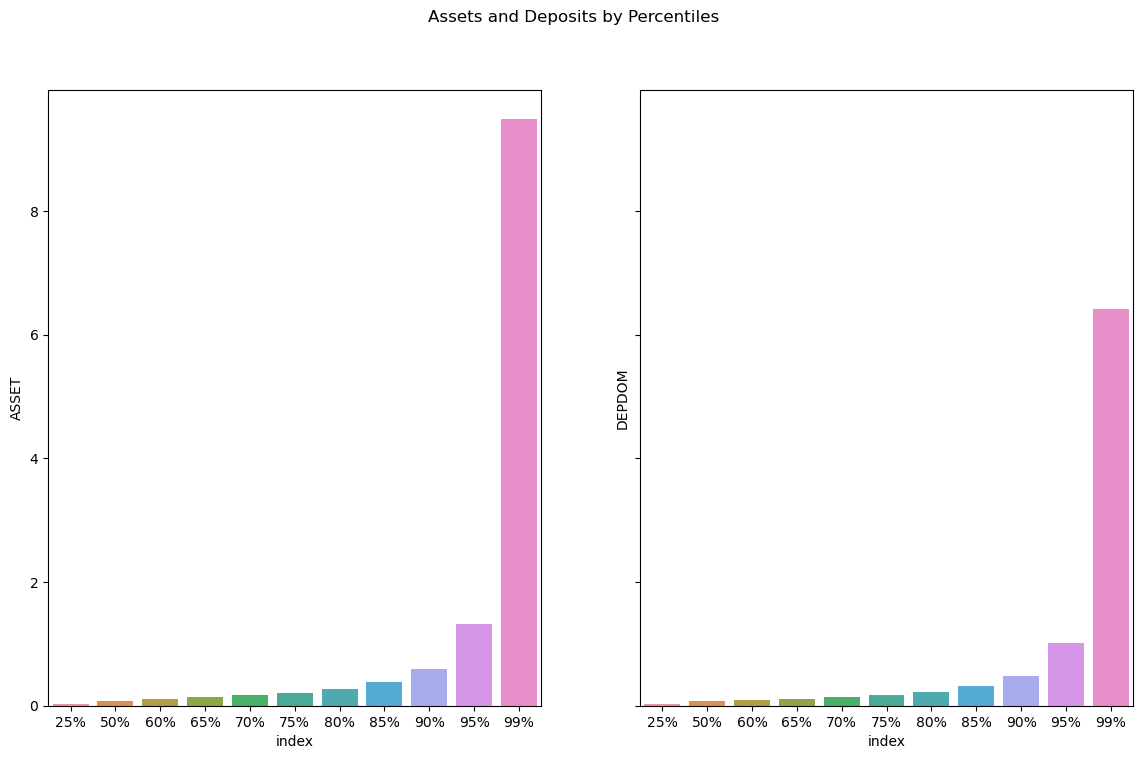

In [31]:
get_fdic_distribution_analysis(fdic_desc)

This dispersion is much more noticeable when using a boxplot graph.  In this case, interquartile box, as well as whiskers, are not visible, meaning that a noticeable group of this data will be displayed in the form of outliers.

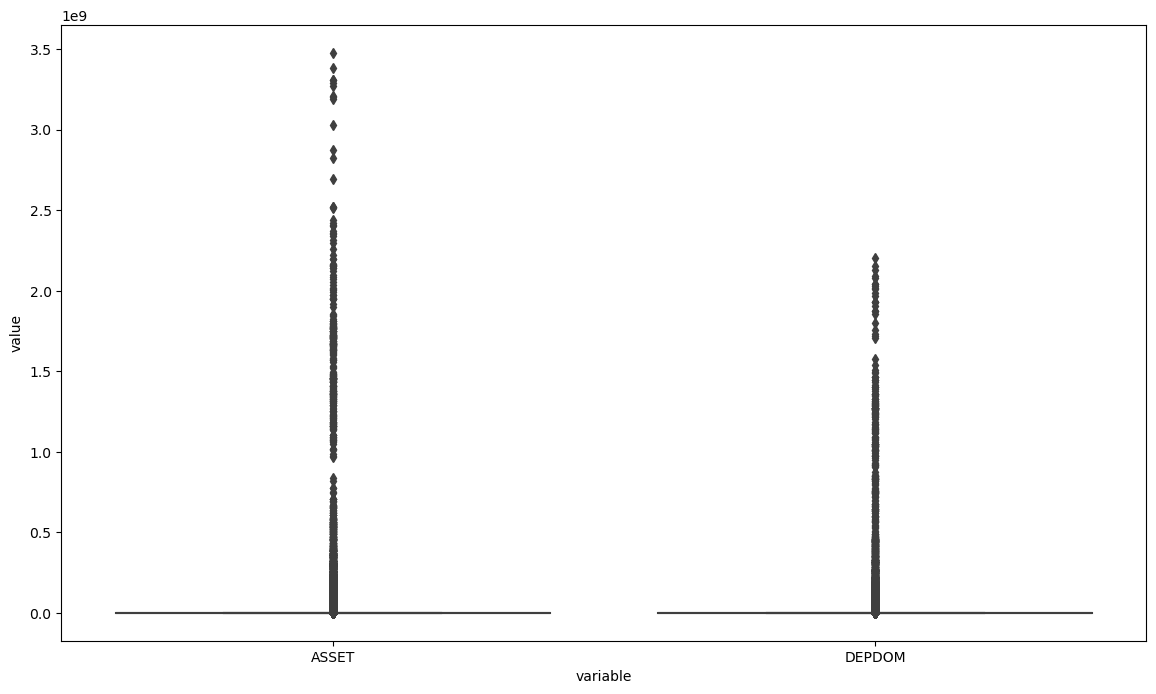

In [32]:
boxplot_graph(df, melt_ = False)

This dispersion started to be much more noticeable after year 2001.  Besides, it is possible COVID-19 could have a role at expanding the gap between banks below 500M and the ones above 1.5B.

On assets...

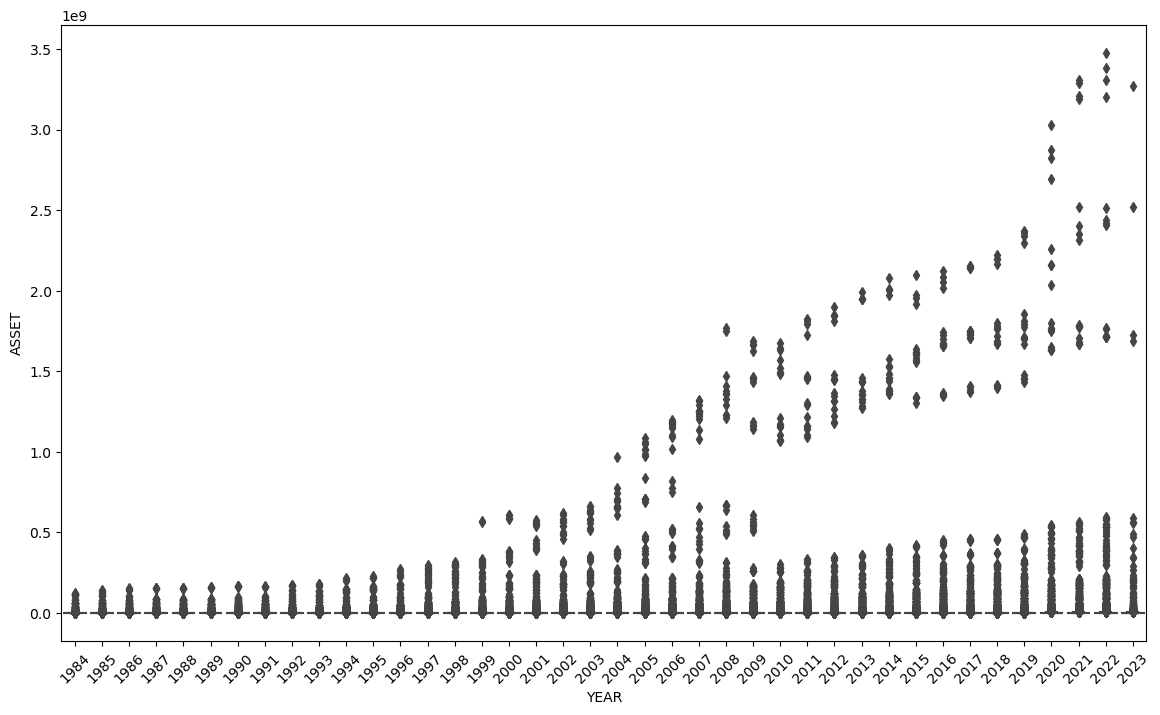

In [33]:
boxplot_graph(df, melt_ = True)

and, on deposits...

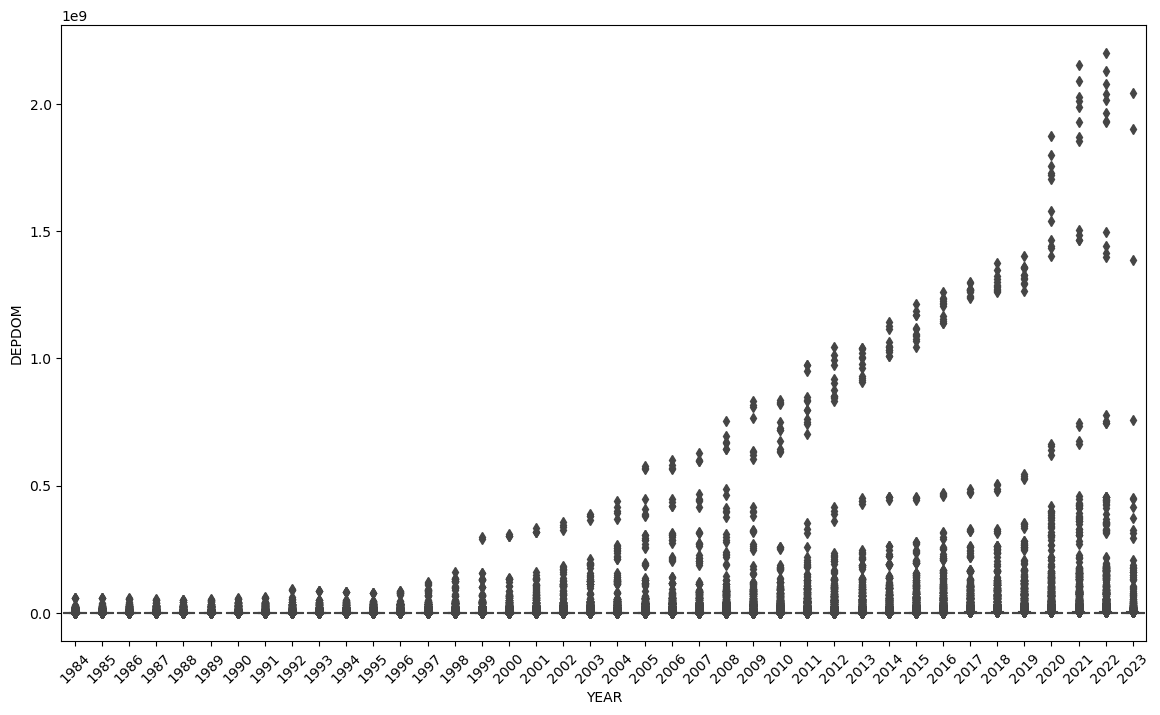

In [34]:
boxplot_graph(df, 'DEPDOM', melt_ = True)

Top percentile data points performed differently since 2016, which made wonder the implied correlation between these features. Below 500M, the slope is steeper than the ones above.

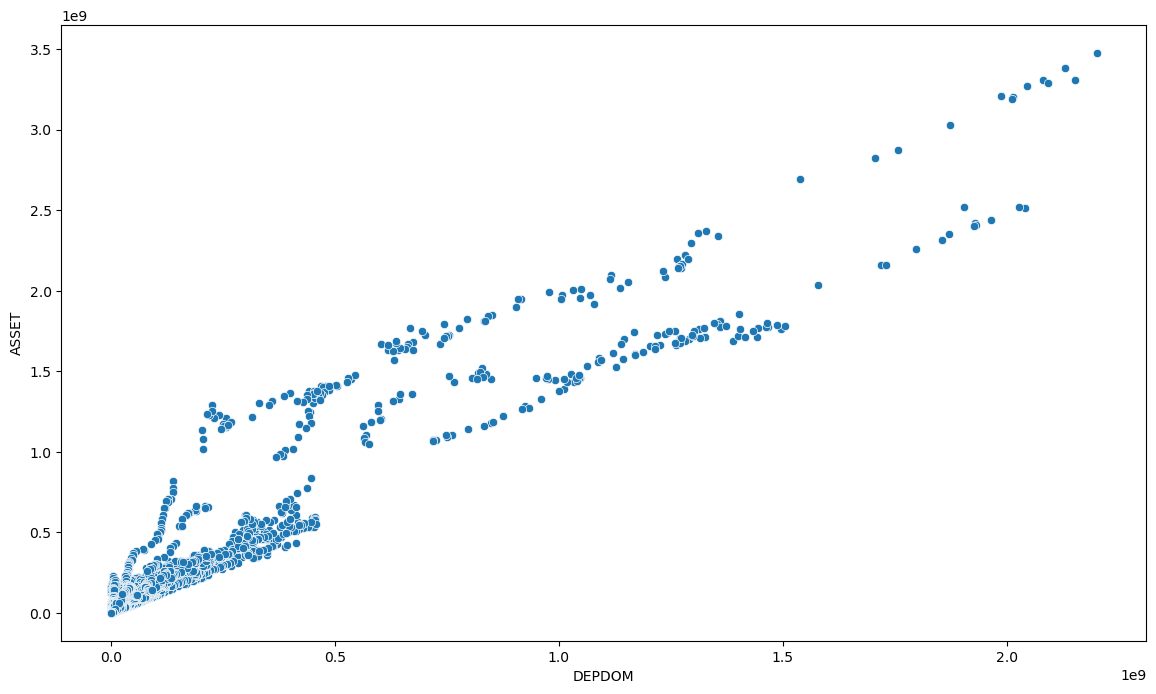

In [35]:
fig, ax = plt.subplots(figsize = (14, 8))
sns.scatterplot(data = df, y = 'ASSET', x = 'DEPDOM', ax = ax)
plt.show()

Calculating correlations by bucket, we got this:

In [36]:
assetsBelow3M = '\nAssets below 3M'
assetsBelow3Mmin = df.loc[df['ASSET'] <= 3e6, ['ASSET', 'DEPDOM']].corr()
print(assetsBelow3M)
display(assetsBelow3Mmin)
assetsBetween3Mand10M = '\nAssets between 3M and 10M'
assetsBetween3Mand10Mmin = df.loc[(df['ASSET'] >= 3e6) & (df['ASSET'] <= 1e7), ['ASSET', 'DEPDOM']].corr()
print(assetsBetween3Mand10M)
display(assetsBetween3Mand10Mmin)
assetsBetween10Mand100M = '\nAssets between 10M and 100M'
assetsBetween10Mand100Mmin = df.loc[(df['ASSET'] >= 1e7) & (df['ASSET'] <= 1e8), ['ASSET', 'DEPDOM']].corr()
print(assetsBetween10Mand100M)
display(assetsBetween10Mand100Mmin)
assetsBetween100Mand1B = '\nAssets between 100M and 1B'
assetsBetween100Mand1Bmin = df.loc[(df['ASSET'] >= 1e8) & (df['ASSET'] <= 1e9), ['ASSET', 'DEPDOM']].corr()
print(assetsBetween100Mand1B)
display(assetsBetween100Mand1Bmin)
assetsMoreThan1B = '\nAssets more than 1B'
assetsMoreThan1Bmin = df.loc[(df['ASSET'] >= 1e9), ['ASSET', 'DEPDOM']].corr()
print(assetsMoreThan1B)
display(assetsMoreThan1Bmin)


Assets below 3M


ASSET   DEPDOM
ASSET   1.00000  0.97804
DEPDOM  0.97804  1.00000


Assets between 3M and 10M


ASSET    DEPDOM
ASSET   1.000000  0.758618
DEPDOM  0.758618  1.000000


Assets between 10M and 100M


ASSET   DEPDOM
ASSET   1.00000  0.85802
DEPDOM  0.85802  1.00000


Assets between 100M and 1B


ASSET    DEPDOM
ASSET   1.000000  0.795515
DEPDOM  0.795515  1.000000


Assets more than 1B


ASSET    DEPDOM
ASSET   1.000000  0.839632
DEPDOM  0.839632  1.000000

Organizing these we find that correlation is higher in the lowest bucket.

''

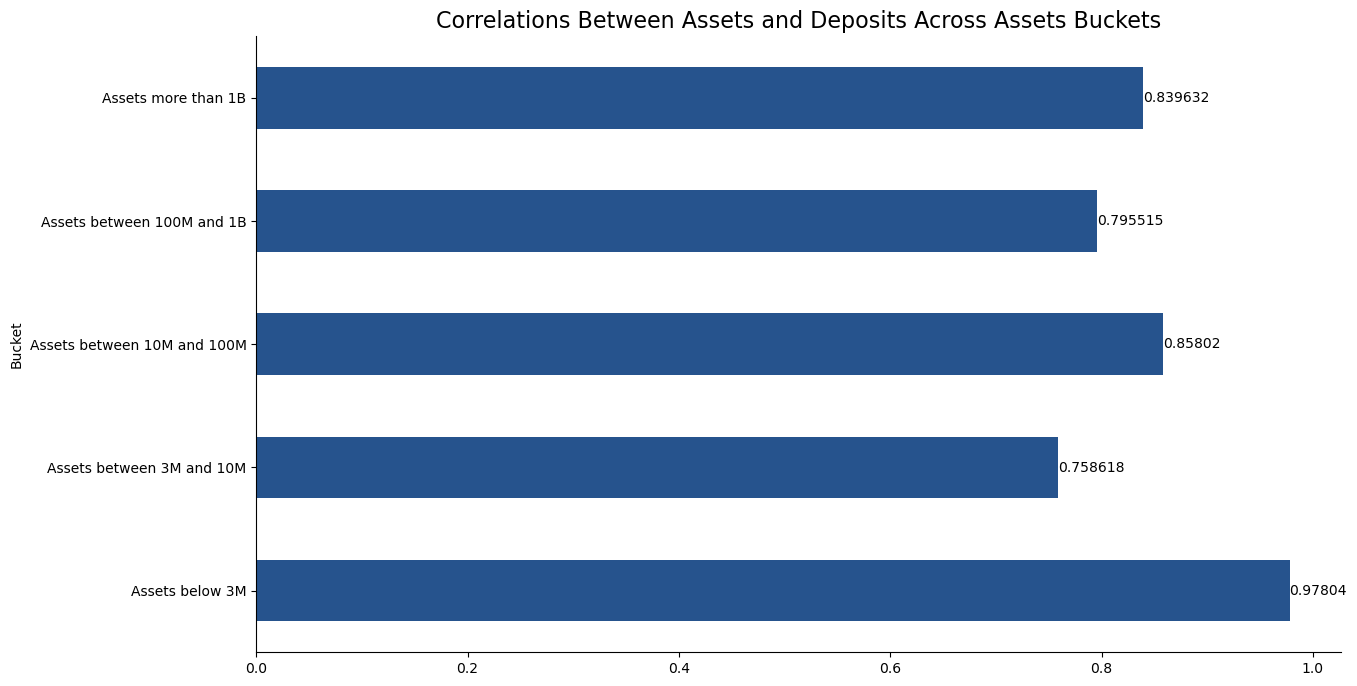

In [37]:
corr_tots = pd.DataFrame({'Bucket':[assetsBelow3M[1:],assetsBetween3Mand10M[1:],assetsBetween10Mand100M[1:],assetsBetween100Mand1B[1:],assetsMoreThan1B[1:]],
                          'Value':[assetsBelow3Mmin.min()[0],assetsBetween3Mand10Mmin.min()[0],assetsBetween10Mand100Mmin.min()[0],assetsBetween100Mand1Bmin.min()[0],assetsMoreThan1Bmin.min()[0]]})
fig, ax = plt.subplots()
ax = corr_tots.set_index('Bucket').plot(kind= 'barh', ax = ax, figsize = (14,8), legend = False, color = '#26538D')
ax.spines[['right', 'top']].set_visible(False)
plt.title("Correlations Between Assets and Deposits Across Assets Buckets", fontsize = 16)

ax.bar_label(ax.containers[0])
;

#### Rates

In [38]:
rates_mask = ['DGS1', 'DGS10', 'DGS1MO', 'DGS2', 'DGS20', 'DGS3','DGS30', 'DGS3MO', 'DGS5', 'DGS6MO', 'DGS7']

In [39]:
rates

date quarter   DGS1  DGS10  DGS1MO   DGS2  DGS20   DGS3  DGS30  \
0     1980-01-01  1980Q1    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
1     1980-01-02  1980Q1  11.89  10.50     NaN  11.39  10.23  10.77  10.23   
2     1980-01-03  1980Q1  12.25  10.60     NaN  11.45  10.37  10.79  10.31   
3     1980-01-04  1980Q1  12.25  10.66     NaN  11.47  10.42  10.81  10.34   
4     1980-01-05  1980Q1    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
...          ...     ...    ...    ...     ...    ...    ...    ...    ...   
15948 2023-08-31  2023Q3   5.37   4.09    5.52   4.85   4.39   4.54   4.20   
15949 2023-09-01  2023Q3    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
15950 2023-09-02  2023Q3    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
15951 2023-09-03  2023Q3    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
15952 2023-09-04  2023Q3    NaN    NaN     NaN    NaN    NaN    NaN    NaN   

       DGS3MO   DGS5  DGS6MO   DGS7  dayofweek  YEAR  
0         NaN    NaN     NaN    NaN    Tuesday  1980  
1         NaN  10.52     NaN  10.51  Wednesday  1980  
2         NaN  10.54     NaN  10.59   Thursday  1980  
3         NaN  10.62     NaN  10.63     Friday  1980  
4         NaN    NaN     NaN    NaN   Saturday  1980  
...       ...    ...     ...    ...        ...   ...  
15948    5.56   4.23    5.48   4.19   Thursday  2023  
15949     NaN    NaN     NaN    NaN     Friday  2023  
15950     NaN    NaN     NaN    NaN   Saturday  2023  
15951     NaN    NaN     NaN    NaN     Sunday  2023  
15952     NaN    NaN     NaN    NaN     Monday  2023  

[15953 rows x 15 columns]

In [40]:
rates_desc = rates.loc[:,rates_mask].describe(percentiles=[.25,.5,.6,.65,.7,.75,.8,.85,.90,.95,.99])
rates_desc.style.format("{:,.2f}")

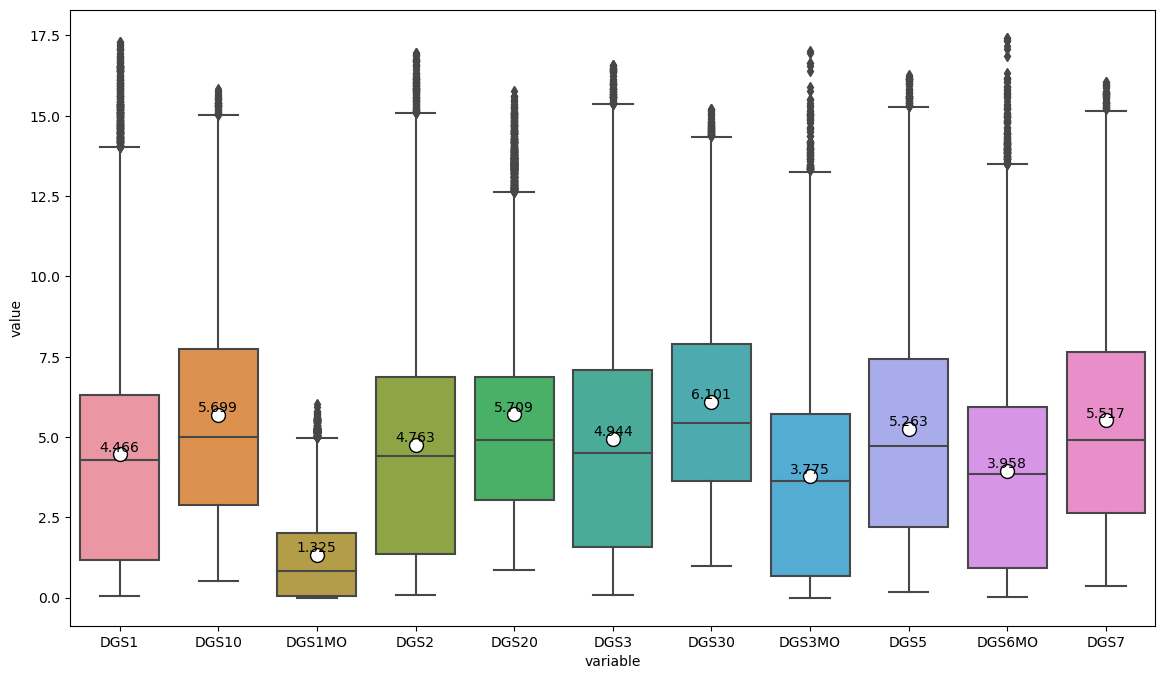

In [41]:
rates_box = pd.melt(rates.loc[:, rates_mask])
rates_box = rates_box.reset_index()

fig, ax = plt.subplots(figsize = (14,8))
ax = sns.boxplot(x="variable", y="value", data=rates_box, showmeans=True, meanprops={"marker":"o",
                                                                                     "markerfacecolor":"white", 
                                                                                     "markeredgecolor":"black",
                                                                                     "markersize":"10"})

                                                                                     
# Annotate the values on the bars
for index, row in enumerate(rates_box.groupby("variable")["value"].mean()):
    ax.text(index, row, str(round(row,3)), ha='center', va='bottom')


plt.show()

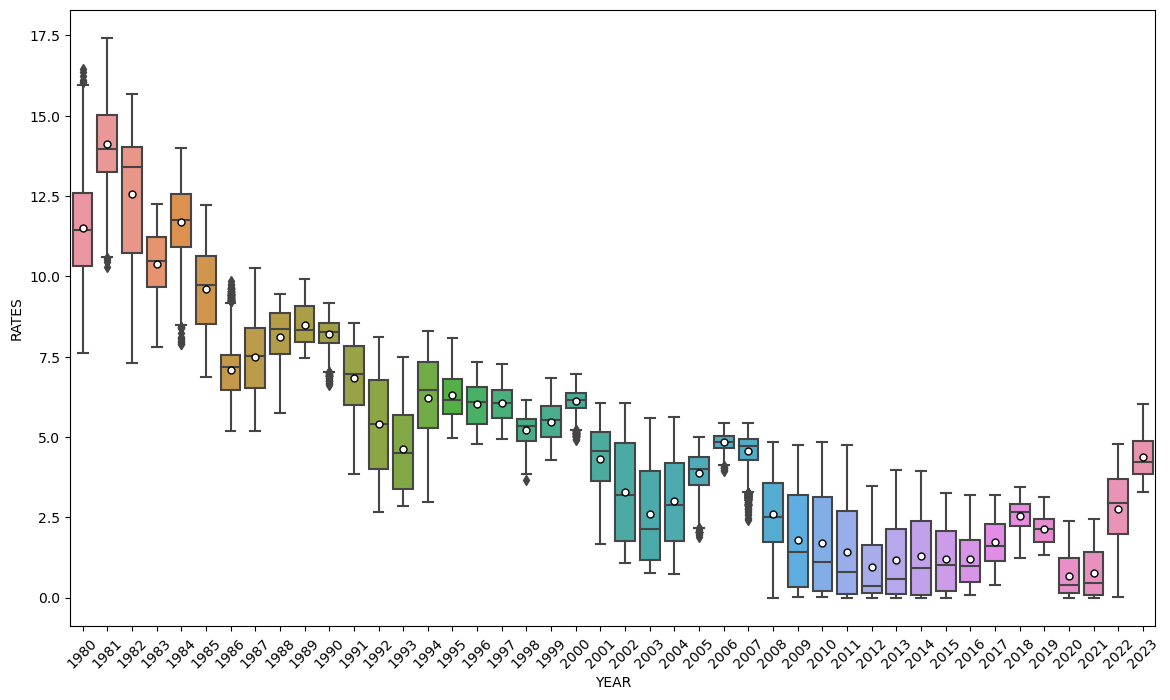

In [42]:


rates_year = pd.DataFrame()

for col in rates.columns: 
    if col not in ('date', 'quarter', 'dayofweek', 'YEAR'):
        rates_year = pd.concat([rates_year, pd.DataFrame({'YEAR': rates.loc[(~rates[col].isnull()),'YEAR'].astype(int), 
                                                          'RATES': rates.loc[(~rates[col].isnull()),col]})])
        
fig, ax = plt.subplots(figsize = (14,8))
ax = sns.boxplot(x="YEAR", y="RATES", data=rates_year, showmeans=True, meanprops={"marker":"o",
                                                                                     "markerfacecolor":"white", 
                                                                                     "markeredgecolor":"black",
                                                                                     "markersize":"5"})
plt.xticks(rotation=45)
plt.show()       
        



#### Stocks Dataset



In [43]:
stocks_mask_desc = ['SP500', 'JPM', 'JPM_Vol', 'BAC', 'BAC_Vol', 'WFC', 'WFC_Vol', 'C', 'C_Vol', 'BK', 'BK_Vol']
stocks_mask_pr = ['JPM', 'BAC', 'WFC', 'C', 'BK']
stocks_mask_vol = ['JPM_Vol', 'BAC_Vol', 'WFC_Vol', 'C_Vol', 'BK_Vol']

In [44]:
stocks_desc = stocks.loc[:,stocks_mask_desc].describe(percentiles=[.25,.5,.6,.65,.7,.75,.8,.85,.90,.95,.99]).style.format("{:,.2f}")
stocks_desc

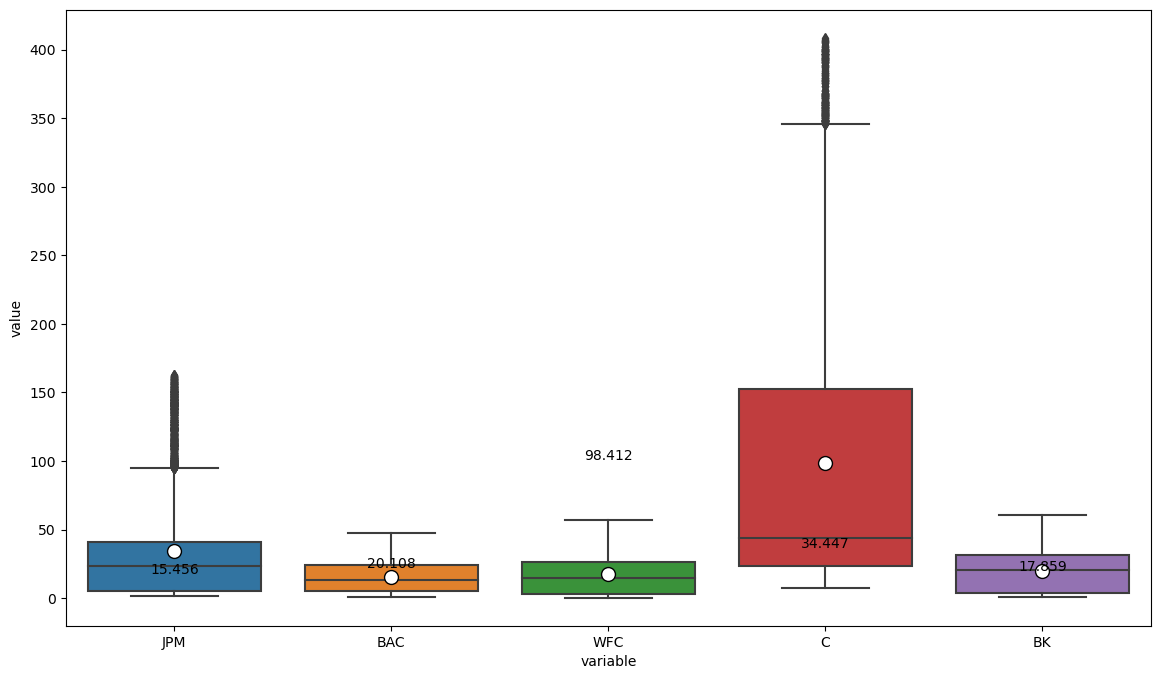

In [45]:
rates_box = pd.melt(stocks.loc[:,stocks_mask_pr])
rates_box = rates_box.reset_index()

fig, ax = plt.subplots(figsize = (14,8))
ax = sns.boxplot(x="variable", y="value", data=rates_box, showmeans=True, meanprops={"marker":"o",
                                                                                     "markerfacecolor":"white", 
                                                                                     "markeredgecolor":"black",
                                                                                     "markersize":"10"})

                                                                                     
# Annotate the values on the bars
for index, row in enumerate(rates_box.groupby("variable")["value"].mean()):
    ax.text(index, row, str(round(row,3)), ha='center', va='bottom')


plt.show()

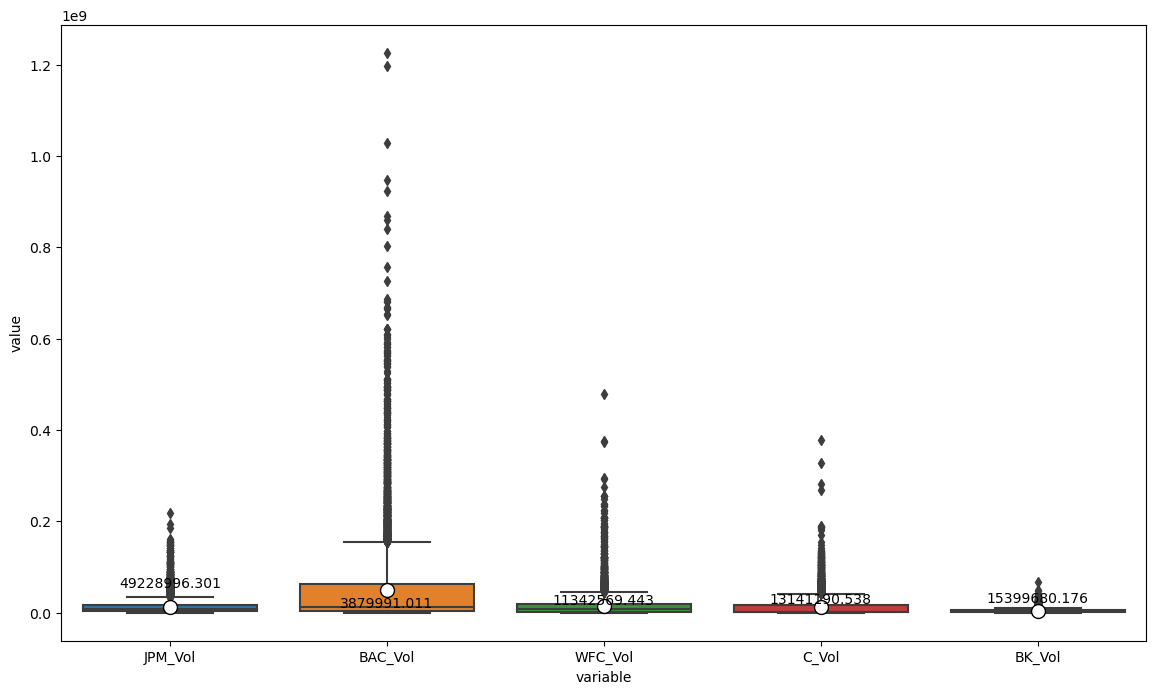

In [46]:
rates_box = pd.melt(stocks.loc[:,stocks_mask_vol])
rates_box = rates_box.reset_index()

fig, ax = plt.subplots(figsize = (14,8))
ax = sns.boxplot(x="variable", y="value", data=rates_box, showmeans=True, meanprops={"marker":"o",
                                                                                     "markerfacecolor":"white", 
                                                                                     "markeredgecolor":"black",
                                                                                     "markersize":"10"})

                                                                                     
# Annotate the values on the bars
for index, row in enumerate(rates_box.groupby("variable")["value"].mean()):
    ax.text(index, row, str(round(row,3)), ha='center', va='bottom')


plt.show()

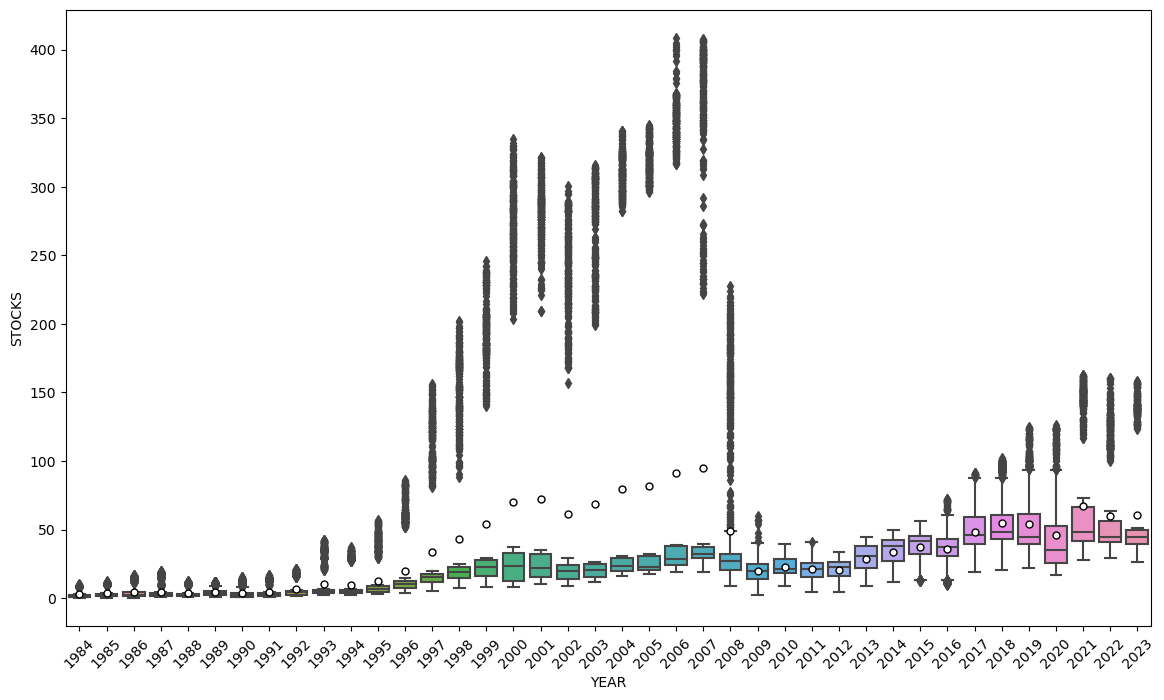

In [47]:
stocks_year = pd.DataFrame()

stock_prices = stocks.loc[:,stocks_mask_pr]

for col in stock_prices.columns: 
    if col not in ('date', 'quarter', 'dayofweek', 'YEAR'):
        stocks_year = pd.concat([stocks_year, pd.DataFrame({'YEAR': stocks.loc[(~stocks[col].isnull()),'YEAR'].astype(int), 
                                                          'STOCKS': stocks.loc[(~stocks[col].isnull()),col]})])
        
fig, ax = plt.subplots(figsize = (14,8))
ax = sns.boxplot(x="YEAR", y="STOCKS", data=stocks_year, showmeans=True, meanprops={"marker":"o",
                                                                                     "markerfacecolor":"white", 
                                                                                     "markeredgecolor":"black",
                                                                                     "markersize":"5"})
plt.xticks(rotation=45)
plt.show()       
        


### Data Preparation

To get bank portfolio data, I will use bank names as defined in the FDIC data as opposed to their corresponding RSSDID number.  I noticed that RSSDID numbers can change overtime, so I would like to keep figures consistent over time.

In [48]:
name_list = ['Bank Of America Na', 'Citibank National Assn', 'Jpmorgan Chase Bank Na', 'Wells Fargo Bank Na']
tsa_df = get_banks_portfolio_dataframe(df, name_list)

In [49]:
tsa_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74 entries, 2004-12-31 to 2023-03-31
Freq: Q-DEC
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Bank Of America Na      74 non-null     float64
 1   Citibank National Assn  74 non-null     float64
 2   Jpmorgan Chase Bank Na  74 non-null     float64
 3   Wells Fargo Bank Na     74 non-null     float64
 4   GROUPTOT                74 non-null     float64
dtypes: float64(5)
memory usage: 3.5 KB


In [50]:
tsa_df.describe().style.format("{:,.2f}")

In [51]:
fig = px.line(tsa_df, x= tsa_df.index, y=tsa_df.columns[:-1], title='TSA Group of Banks')
fig.show()

In [52]:
df_grouped = add_noise_to_feature(df, "REPDTE", "ASSET")
tsa_df =pd.merge(df_grouped, tsa_df, how = "left", right_index = True, left_index =True)

tsa_df

ASSET  ASSETPCTCHG       ASSETWN  Bank Of America Na  \
1984-03-31   3379075626          NaN  1.642549e+10                 NaN   
1984-06-30   3484668147     3.124894  1.221847e+10                 NaN   
1984-09-30   3526114901     1.189403  1.410289e+10                 NaN   
1984-12-31   3659560992     3.784508  7.208042e+09                 NaN   
1985-03-31   3672403703     0.350936  1.144272e+10                 NaN   
...                 ...          ...           ...                 ...   
2022-03-31  24156644375     0.904005 -1.317811e+09        2.513619e+09   
2022-06-30  23900077876    -1.062095  9.727566e+09        2.440022e+09   
2022-09-30  23813293726    -0.363112  8.554023e+09        2.407902e+09   
2022-12-31  23801187570    -0.050838  1.544643e+10        2.418508e+09   
2023-03-31  23928749277     0.535947  1.523914e+10        2.518290e+09   

            Citibank National Assn  Jpmorgan Chase Bank Na  \
1984-03-31                     NaN                     NaN   
1984-06-30                     NaN                     NaN   
1984-09-30                     NaN                     NaN   
1984-12-31                     NaN                     NaN   
1985-03-31                     NaN                     NaN   
...                            ...                     ...   
2022-03-31            1.718008e+09            3.476711e+09   
2022-06-30            1.720308e+09            3.380824e+09   
2022-09-30            1.714474e+09            3.308575e+09   
2022-12-31            1.766752e+09            3.201942e+09   
2023-03-31            1.721547e+09            3.267963e+09   

            Wells Fargo Bank Na      GROUPTOT  
1984-03-31                  NaN           NaN  
1984-06-30                  NaN           NaN  
1984-09-30                  NaN           NaN  
1984-12-31                  NaN           NaN  
1985-03-31                  NaN           NaN  
...                         ...           ...  
2022-03-31         1.764272e+09  9.472610e+09  
2022-06-30         1.712535e+09  9.253689e+09  
2022-09-30         1.712442e+09  9.143393e+09  
2022-12-31         1.717531e+09  9.104733e+09  
2023-03-31         1.687507e+09  9.195307e+09  

[157 rows x 8 columns]

In [53]:
selected_banks_df = tsa_df.dropna()

fig = px.line(selected_banks_df, x= selected_banks_df.index, y="GROUPTOT", title='TSA Selected Banks -- Banks Portfolio Assets')
fig.show()

In [54]:
tsa_df.describe().style.format("{:,.2f}")

''

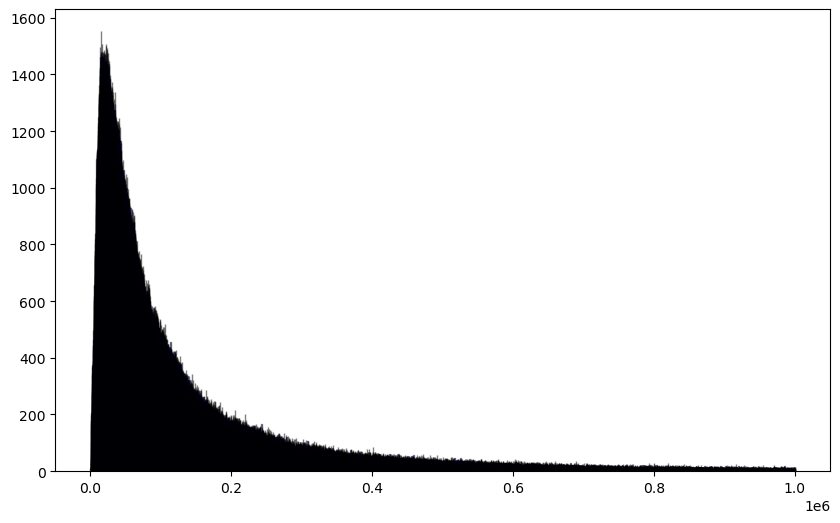

In [55]:
plt.figure(figsize=(10, 6))  # Set figure size

asset = df.loc[df['ASSET'] <= 1e6, 'ASSET']
plt.hist(asset, bins=10000, color='blue', edgecolor='black', alpha=0.5, label='Asset Size')
;

<Axes: ylabel='ASSET'>

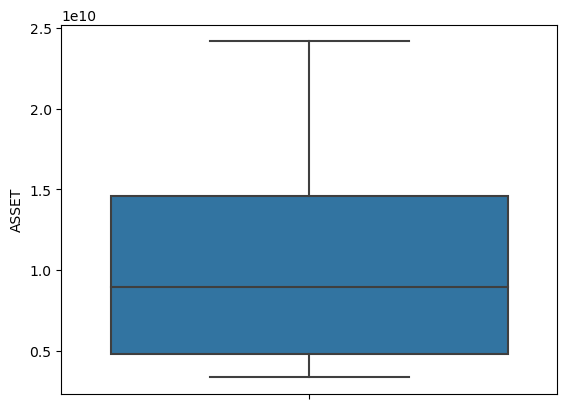

In [56]:
sns.boxplot(data = tsa_df, y =  "ASSET")

In [57]:
fig = px.line(tsa_df, x= tsa_df.index, y="ASSET", title='TSA Aggregated since 1985 -- Total Assets')
fig.show()

### Time Series Decomposition

C:\Users\johnh\anaconda3\envs\tsa365ds2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



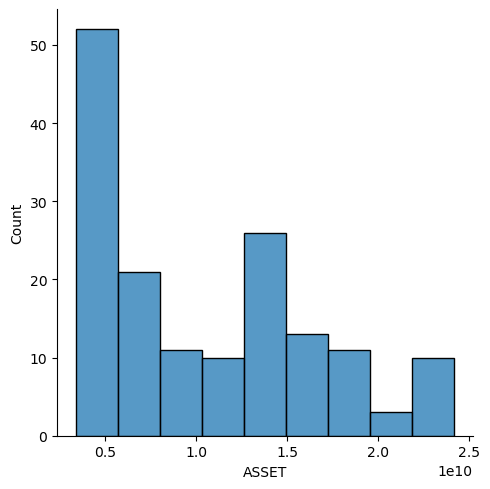

In [58]:
sns.displot(tsa_df, x="ASSET")

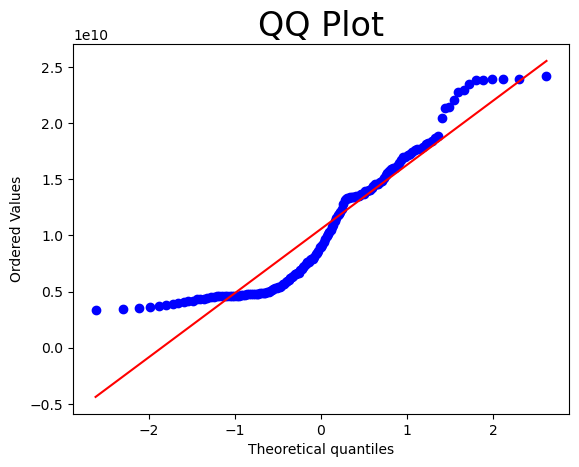

In [59]:
scipy.stats.probplot(tsa_df["ASSET"], plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

QQ plot shows that the data is not stationary.  I know, we already saw that upstairs.  Nonetheless, let's use to further test stationarity in our data

In [60]:
augmented_df_with_data(tsa_df["ASSET"])

Augmented Dickey-Fuller Test
ADF test statistic:            1.565162
p-value:                       0.997749
# lags used:                   3.000000
# observations:              153.000000
critical value at (1%):       -3.473830
critical value at (5%):       -2.880623
critical value at (10%):      -2.576945
Best AIC:                   5799.384410
dtype: float64


Nope.  It is NOT.

Let's then analyze trend, seasonality and reseiduals at both multiplicative and additive.

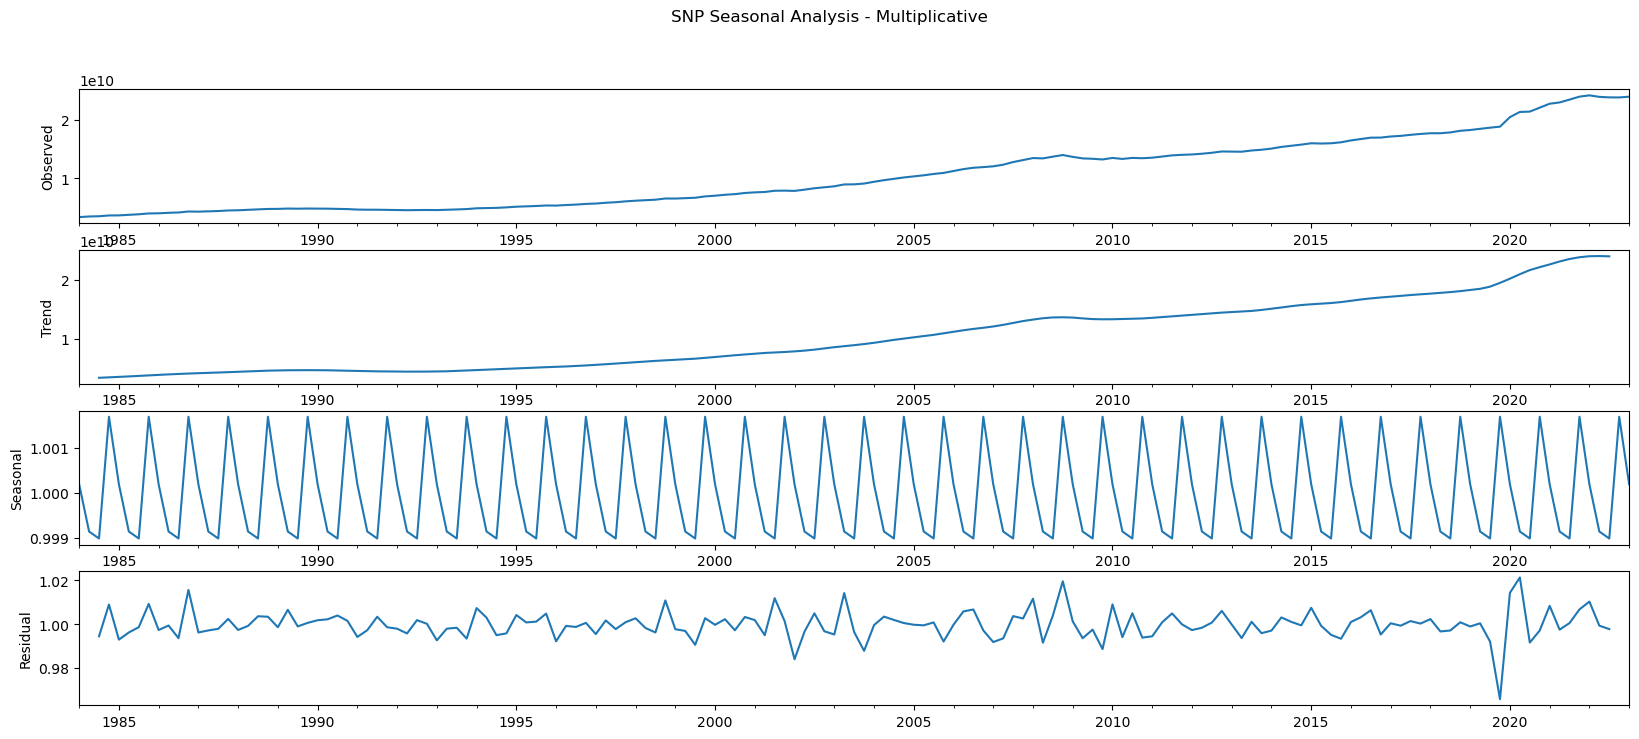

In [61]:
seasonal_decompose_groomed(tsa_df["ASSET"], 'multiplicative', 'SNP Seasonal Analysis - Multiplicative')

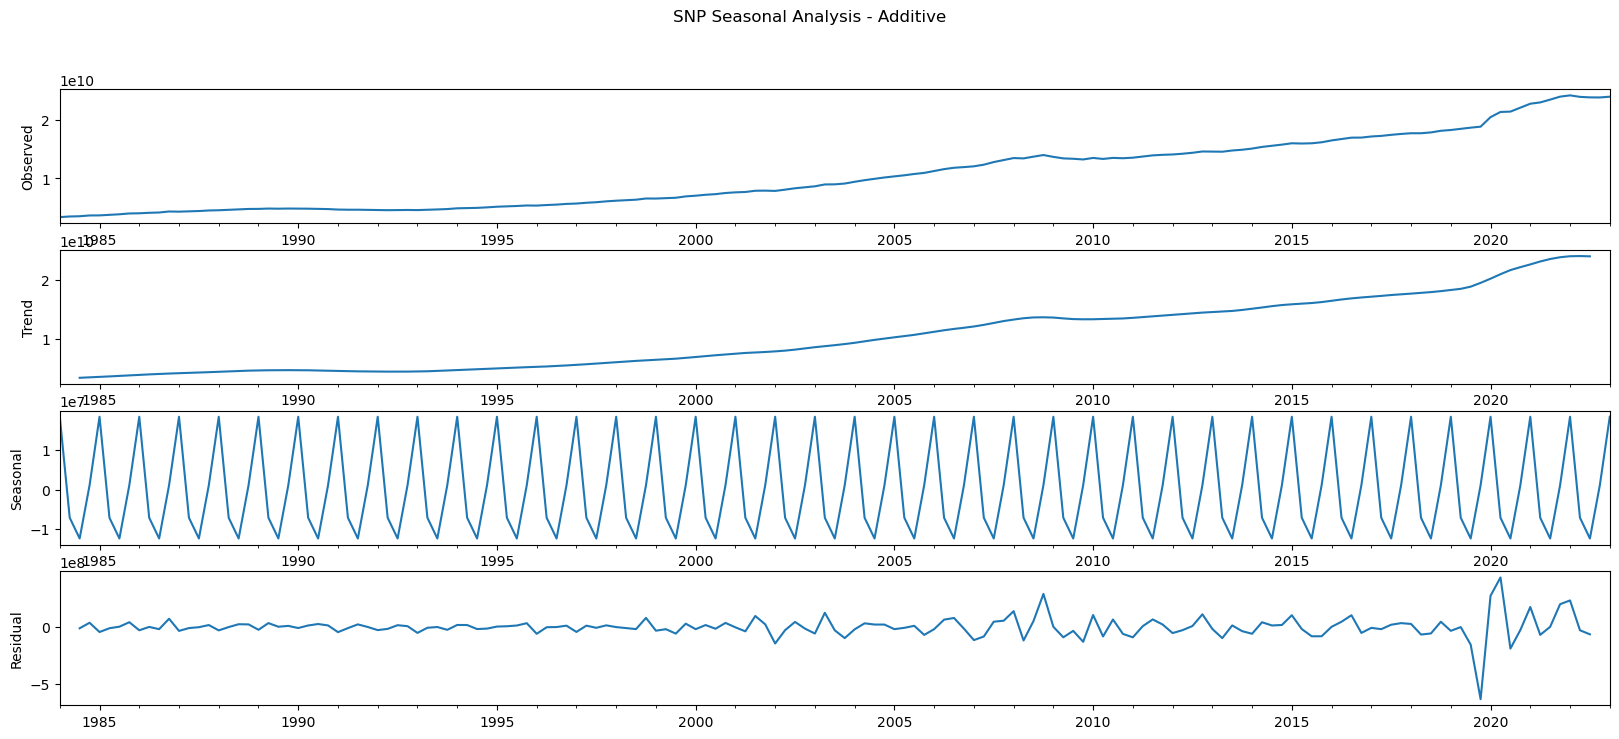

In [62]:
seasonal_decompose_groomed(tsa_df["ASSET"], 'additive', 'SNP Seasonal Analysis - Additive')

''

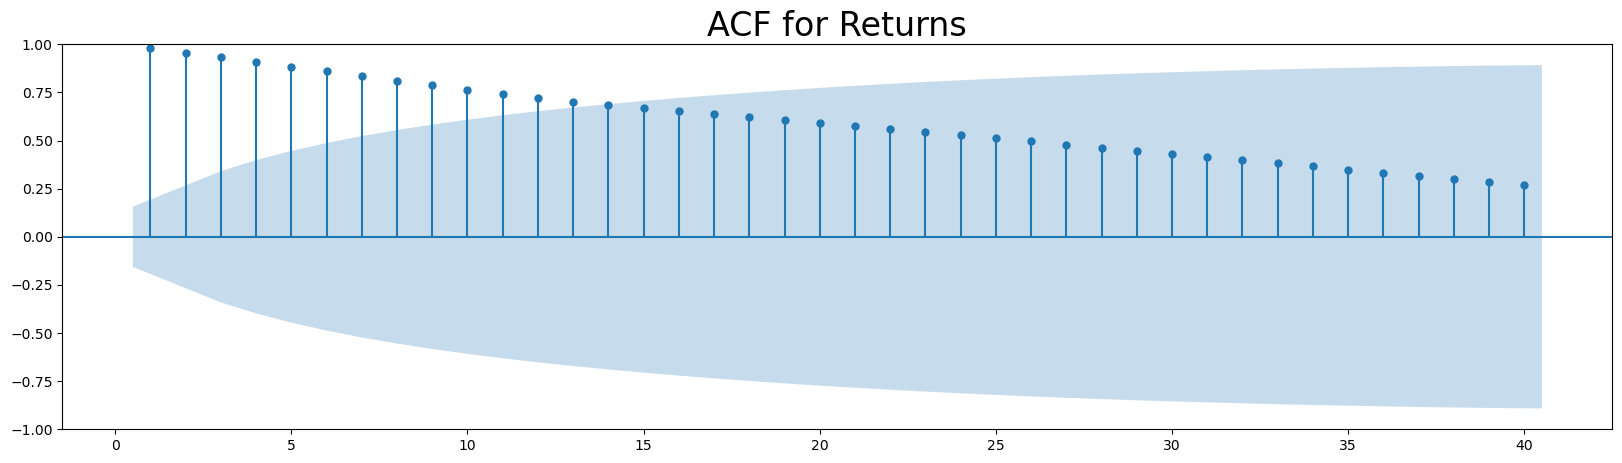

In [63]:
fig, ax = plt.subplots(figsize = (20, 5))
sgt.plot_acf(tsa_df["ASSET"], zero= False, lags= 40, ax= ax)
plt.title('ACF for Returns', size= 24)
;

''

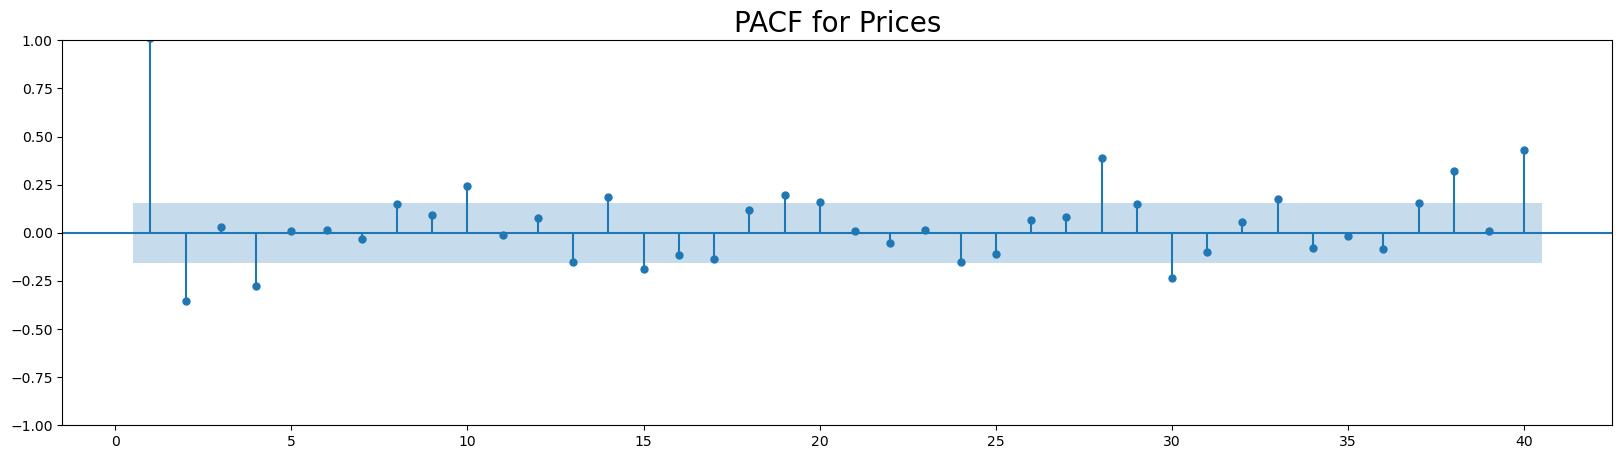

In [64]:
fig, ax = plt.subplots(figsize = (20, 5))
sgt.plot_pacf(tsa_df["ASSET"], zero = False, lags = 40, alpha = 0.05, method = ('ols'), ax = ax)
plt.title('PACF for Prices', size = 20)
;

In [65]:
# tsa_df

### Analysis on all data series

Analyze data with the following methods:
1. Hodrick–Prescott filter: Cycle
1. Hodrick–Prescott filter: Trend
1. Expanding windnow calculations
1. Simple Moving Average (SMA)
1. Exponentially Weighted Moving Average (EWMA)
1. Simple Exponential Smoothing
1. Holt-Winters: Double Exponential Smoothing - Additive
1. Holt-Winters: Double Exponential Smoothing - Multiplicative
1. Holt-Winters: Triple Exponential Smoothing - Additive
1. Holt-Winters: Triple Exponential Smoothing - Multiplicative

In [66]:
asset_cycle, asset_trend = hpfilter(tsa_df["ASSET"], lamb = 1600)

span = 4
alpha = 1/(span+1)

tsa_df['ASSETTRN'] = asset_trend
# Expanding
tsa_df["ASSTEXPND12"] = tsa_df["ASSET"].expanding(min_periods=4).mean()
# SMA by 4 periods
tsa_df["ASSTRLLNG12"] = tsa_df["ASSET"].rolling(window=4).mean()
# Exponentially Weighted Moving Average (EWMA)
tsa_df['ASSTEWMA12'] = tsa_df["ASSET"].ewm(span = 4, adjust = False).mean()
# Simple Exponential Smoothing
tsa_df['ASSTSES12'] = SimpleExpSmoothing(tsa_df["ASSET"]).fit(smoothing_level= alpha,optimized=False).fittedvalues.shift(-1)
# Double Exponential Smoothing DES
tsa_df['ASSTSDESadd12'] = ExponentialSmoothing(tsa_df["ASSET"], 
                                          trend='add',
                                          initialization_method="known",
                                          initial_level = 200,
                                          initial_trend = 4     
                                              ).fit(method='basinhopping').fittedvalues.shift(-1)
tsa_df['ASSTSDESmul12'] = ExponentialSmoothing(tsa_df["ASSET"], 
                                          trend='mul',
                                          initialization_method= None,
                                           seasonal_periods= 4
                                         ).fit(method='least_squares').fittedvalues.shift(-1)
# Tripple Exponential Smoothing TES
tsa_df['ASSTSTESadd12'] = ExponentialSmoothing(tsa_df["ASSET"], 
                                          trend='add',
                                          seasonal= "add",
                                          seasonal_periods= 4, 
                                          initialization_method="known",
                                          initial_level = 200,
                                          initial_trend = 4,
                                          initial_seasonal = 5
                                         ).fit(method='basinhopping').fittedvalues.shift(-1)
tsa_df['ASSTSTESmul12'] = ExponentialSmoothing(tsa_df["ASSET"], 
                                          trend='mul',
                                          seasonal= "mul",
                                          seasonal_periods= 4, 
                                          initialization_method= None
                                         ).fit(method='least_squares').fittedvalues.shift(-1)

In [67]:
# tsa_df

In [68]:
series = ["ASSET","ASSETTRN", "ASSTEXPND12", "ASSTRLLNG12", "ASSTEWMA12", "ASSTSES12", "ASSTSES12",
         "ASSTSDESadd12", "ASSTSDESmul12", "ASSTSTESadd12", "ASSTSTESmul12"]
fig = px.line(tsa_df, x= tsa_df.index, y= series, title='TSA Aggregated since 1985')
fig.show()

In [69]:
fig = px.line(tsa_df, x= tsa_df.index, y="ASSETWN", title='TSA Aggregated since 1985 -- White Noise')
fig.show()

In [70]:
tsa_df_prov = tsa_df.loc["1984-06-30":]
fig = px.line(tsa_df_prov, x= tsa_df_prov.index, y="ASSETPCTCHG", title='TSA Aggregated since 1985 -- Percentage Change')
fig.show()

In [71]:
# tsa_df.to_csv('tsa_df_pre_forecast.csv')

After adjusting ExponentialSmoothing to reach convergence, we find that these approaches fit very well the data.  I intend to furhter test this by forecasting the data. in the following section.


Portfolio TSA lines made me believe that they are the market makers in this analysis.  I would like to explore this relationship later in the analysis.  However, I will focus on the total assets behavior and then use the other banks to adjust forecast.

### Forecast approaches

These will be our forecasting methods for analysis purposes:
1. Simple Exponential Smoothing
1. Holt-Winters: Double Exponential Smoothing - Additive
1. Holt-Winters: Double Exponential Smoothing - Multiplicative
1. Holt-Winters: Triple Exponential Smoothing - Additive
1. Holt-Winters: Triple Exponential Smoothing - Multiplicative
1. ARIMA
1. SARIMAX
1. LSTM
1. XGBoost


I currently use 10 quarters of prediction data for this exercise.  I would NOT use so many quarters if this model would be productionize.

In [72]:
threshold_period = tsa_df.index[-10]

In [73]:
train_tsa = tsa_df.iloc[tsa_df.index  < threshold_period]
test_tsa = tsa_df[threshold_period:]

In [74]:
len(test_tsa)

10

In [75]:
# train_tsa.tail()

In [76]:
# test_tsa.head()

In [77]:
ses24fittedmodel = SimpleExpSmoothing(train_tsa["ASSET"]).fit(smoothing_level= alpha,optimized=False)
desadd24fitteddmodel = ExponentialSmoothing(train_tsa["ASSET"], 
                                          trend='add',
                                          initialization_method="known",
                                          initial_level = 200,
                                          initial_trend = 4     
                                              ).fit(method='basinhopping')
desmul24fittedmodel = ExponentialSmoothing(train_tsa["ASSET"], 
                                          trend='mul',
                                          initialization_method= None,
                                           seasonal_periods= 4
                                         ).fit(method='least_squares')
# Tripple Exponential Smoothing TES
tesadd24fitteddmodel = ExponentialSmoothing(train_tsa["ASSET"], 
                                          trend='add',
                                          seasonal= "add",
                                          seasonal_periods= 4, 
                                          initialization_method="known",
                                          initial_level = 200,
                                          initial_trend = 4,
                                          initial_seasonal = 5
                                         ).fit(method='basinhopping')
tesmul24fitteddmodel = ExponentialSmoothing(train_tsa["ASSET"], 
                                          trend='mul',
                                          seasonal= "mul",
                                          seasonal_periods= 4, 
                                          initialization_method= None
                                         ).fit(method='least_squares')

In [78]:
tsa_df['ASSTSESPred24'] = ses24fittedmodel.forecast(len(test_tsa))
tsa_df['ASSTDESaddPred24'] = desadd24fitteddmodel.forecast(len(test_tsa))
tsa_df['ASSTDESmulPred24'] = desmul24fittedmodel.forecast(len(test_tsa))
tsa_df['ASSTsTESaddPred24'] = tesadd24fitteddmodel.forecast(len(test_tsa))
tsa_df['ASSTsTESmulPred24'] = tesmul24fitteddmodel.forecast(len(test_tsa))

In [79]:
tsa_df.to_csv('time_series_data_n_forecast,csv', index = False)

In [80]:
# Create the train and test lines
train_trace = go.Scatter(x=train_tsa.index, y=train_tsa['ASSET'], mode='lines', name='Train Data')
test_trace = go.Scatter(x=test_tsa.index, y=test_tsa['ASSET'], mode='lines', name='Test Data')
test_predses = go.Scatter(x=tsa_df.index, y=tsa_df['ASSTSESPred24'], mode='lines', name='ASSTSESPred24')
test_preddesadd = go.Scatter(x=tsa_df.index, y=tsa_df['ASSTDESaddPred24'], mode='lines', name='ASSTDESaddPred24')
test_preddesmul = go.Scatter(x=tsa_df.index, y=tsa_df['ASSTDESmulPred24'], mode='lines', name='ASSTDESmulPred24')
test_predtesadd = go.Scatter(x=tsa_df.index, y=tsa_df['ASSTsTESaddPred24'], mode='lines', name='ASSTsTESaddPred24')
test_predtesmul = go.Scatter(x=tsa_df.index, y=tsa_df['ASSTsTESmulPred24'], mode='lines', name='ASSTsTESmulPred24')


# Create the figure and add the traces
fig = go.Figure(data=[train_trace, test_trace, test_predses, test_preddesadd, test_preddesmul,
                      test_predtesadd, test_predtesmul])

# Customize the layout
fig.update_layout(
    title='Train vs. Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
)

# Show the plot
fig.show()


In [81]:

model_list = ['Simple Exponential Smoothing', 'Double Exponential Smoothing - Additive',
              'Double Exponential Smoothing - Multiplicative', 'Triple Exponential Smoothing - Additive',
              'Triple Exponential Smoothing - Multiplicative']
model_results = ['ASSTSESPred24', 'ASSTDESaddPred24', 'ASSTDESmulPred24', 'ASSTsTESaddPred24', 'ASSTsTESmulPred24']


df_validation = pd.DataFrame()

Validation results resulting from this analysis are:

In [82]:
df_validation = validation_estimation(tsa_df, df_validation, model_list, model_results, field = 'ASSET', thresh = -10)

In [83]:
dict_cols = [col for col in df_validation.columns.values if col != 'Approach']
format_dict = {}
for col in dict_cols: format_dict[col] = "{:,.2f}"
val = df_validation.copy()
val.style.format(format_dict)

Triple Exponential Smoothing - Additive is the best metric, so far.

### Autoregressive

In [84]:
model_ret_ma_1 = ARIMA(tsa_df["ASSET"][1:, ], order = (1,1,1), freq = "Q-DEC")
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  ASSET   No. Observations:                  156
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3181.756
Date:                Wed, 27 Sep 2023   AIC                           6369.512
Time:                        21:03:29   BIC                           6378.642
Sample:                    06-30-1984   HQIC                          6373.220
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9476      0.030     32.104      0.000       0.890       1.005
ma.L1         -0.8744      0.046    -19.061      0.000      -0.964      -0.785
sigma2      3.418e+16        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                  20.17   Jarque-Bera (JB):              3357.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.58   Skew:                             2.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.06e+50. Standard errors may be unstable.
"""